In [9]:
# Import required modules
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import warnings

warnings.filterwarnings('ignore')
print("Modules loaded.")

Modules loaded.


In [2]:
# Define experiment and variable
years = np.arange(1950, 2101, 1)
variable = 'tasmax'
experiment = 'ssp585'

In [16]:
# Load GPW and WorldPop population data
datadir = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_pop_gpw = 'gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_nclimgrid_min.nc'
ds_pop_gpw = xr.open_dataset(os.path.join(datadir, fname_pop_gpw))
da_pop_gpw = ds_pop_gpw['population'].where(ds_pop_gpw['population'] > 0)

fname_pop = 'usa_ppp_2020_UNadj_constrained_resample_sum_nclimgrid.nc'
ds_pop = xr.open_dataset(os.path.join(datadir, fname_pop))
da_pop = ds_pop['population'].where(ds_pop['population'] > 0)

# Regrid WorldPop to GPW grid
regridder = xe.Regridder(da_pop, da_pop_gpw, "bilinear")
da_pop = regridder(da_pop)

In [17]:
# Load SVI and state mask data
fname_svi = 'svi_2020_tract_overall_nclimgrid.nc'
ds_svi = xr.open_dataset(os.path.join(datadir, fname_svi))
da_svi = ds_svi['svi']

fname_states = 'State_ID_from_zhouCroppedForStates_nclimgrid.nc'
ds_states = xr.open_dataset(os.path.join(datadir, fname_states))
da_states = ds_states['ID']

In [18]:
# load nclimgrid data
fname_nclimgrid = 'nclimgrid_conus_tasmax_annual_1993_2023.nc'
ds_tasmax = xr.open_dataset(os.path.join(datadir,fname_nclimgrid))
nclimgrid_tasmax = ds_tasmax['tasmax_annual'].sel(time=slice(1994,2023))
nclimgrid_tasmax

<xarray.DataArray 'tasmax_annual' (time: 30, lat: 596, lon: 1385)> Size: 198MB
[24763800 values with dtype=float64]
Coordinates:
  * time     (time) int32 120B 1994 1995 1996 1997 1998 ... 2020 2021 2022 2023
  * lat      (lat) float32 2kB 24.56 24.6 24.65 24.69 ... 49.27 49.31 49.35
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02

In [26]:
temps = ['1','1.5','2','2.5','3','3.5','4']
# Load CMIP6 warming level CSV
fname_gwl_csv = 'CMIP6_STARESDM_Models_GWLevels_ssp585.csv'
usecols = ['CMIP6 Model','1','1.5','2','2.5','3','3.5','4']
gwls = pd.read_csv(os.path.join(datadir, fname_gwl_csv), usecols=usecols)
models = gwls['CMIP6 Model']
gwls.head()


,CMIP6 Model,1,1.5,2,2.5,3,3.5,4
0,ACCESS-CM2,2015,2026,2039,2048,2056,2064,2071.0
1,ACCESS-ESM1-5,2013,2028,2039,2051,2061,2071,2079.0
2,BCC-CSM2-MR,2017,2031,2044,2055,2066,2078,2091.0
3,CMCC-ESM2,2004,2029,2040,2048,2055,2063,2071.0
4,CanESM5,2000,2012,2023,2033,2041,2048,2055.0


In [23]:
# List CMIP6 threshold files
threshold_dir = os.path.join(datadir, 'staresdm_annual_tasmax')
cmip6_files = sorted([f for f in os.listdir(threshold_dir) if f.endswith('.nc')])
print(f"Found {len(cmip6_files)} CMIP6 threshold files.")
cmip6_files[:5]  # Show first few files

Found 22 CMIP6 threshold files.


['staresdm_ACCESS-CM2_ssp585_conus_tasmax_1950_2100.nc',
 'staresdm_ACCESS-ESM1-5_ssp585_conus_tasmax_1950_2100.nc',
 'staresdm_BCC-CSM2-MR_ssp585_conus_tasmax_1950_2100.nc',
 'staresdm_CMCC-ESM2_ssp585_conus_tasmax_1950_2100.nc',
 'staresdm_CanESM5_ssp585_conus_tasmax_1950_2100.nc']

In [27]:
%%time

cmip6_models = []

for fi,fname in enumerate(cmip6_files):

    print(fname)
    
    ds = xr.open_dataset(os.path.join(datadir,'staresdm_annual_tasmax',fname))
    da = ds[str(variable)]
    if da.time[0] < 1950:
        print('warning! years are weird, there is a year <1950! Replacing year')
        da['time'] = np.arange(1950,2101,1)
    model_name = fname.split('_')[1]
    cmip6_models.append(model_name)
    
    for ti,temp in enumerate(temps):
        
        if pd.isnull(gwls[str(temp)][fi]):
            
            da_slice = da.sel(time=slice(1951,1970)).mean(dim='time')
            da_slice = da_slice.where(da_slice<0,'nan')
            da_slice = da_slice.assign_coords(gwl=temp)
            
        else:
            yr = int(np.array(gwls[str(temp)][fi]))
            
            da_slice = da.sel(time=slice(yr-9,yr+10)).mean(dim='time')
            da_slice = da_slice.assign_coords(gwl=temp)

        if ti == 0:
            da_slice_all_gwls = da_slice
        else:
            da_slice_all_gwls = xr.concat((da_slice_all_gwls,da_slice),dim='gwl')
            
    if  fi == 0:
        da_slice_all_gwls_allmodels = da_slice_all_gwls
    else:
        da_slice_all_gwls_allmodels = xr.concat((da_slice_all_gwls_allmodels,da_slice_all_gwls),dim='model')
       

staresdm_ACCESS-CM2_ssp585_conus_tasmax_1950_2100.nc
warning! years are weird, there is a year <1950! Replacing year
staresdm_ACCESS-ESM1-5_ssp585_conus_tasmax_1950_2100.nc
staresdm_BCC-CSM2-MR_ssp585_conus_tasmax_1950_2100.nc
staresdm_CMCC-ESM2_ssp585_conus_tasmax_1950_2100.nc
staresdm_CanESM5_ssp585_conus_tasmax_1950_2100.nc
staresdm_EC-Earth3-Veg-LR_ssp585_conus_tasmax_1950_2100.nc
staresdm_EC-Earth3_ssp585_conus_tasmax_1950_2100.nc
staresdm_FGOALS-g3_ssp585_conus_tasmax_1950_2100.nc
staresdm_GFDL-CM4_ssp585_conus_tasmax_1950_2100.nc
staresdm_GFDL-ESM4_ssp585_conus_tasmax_1950_2100.nc
staresdm_INM-CM4-8_ssp585_conus_tasmax_1950_2100.nc
staresdm_INM-CM5-0_ssp585_conus_tasmax_1950_2100.nc
staresdm_IPSL-CM6A-LR_ssp585_conus_tasmax_1950_2100.nc
staresdm_KACE-1-0-G_ssp585_conus_tasmax_1950_2100.nc
staresdm_KIOST-ESM_ssp585_conus_tasmax_1950_2100.nc
staresdm_MIROC6_ssp585_conus_tasmax_1950_2100.nc
staresdm_MPI-ESM1-2-HR_ssp585_conus_tasmax_1950_2100.nc
staresdm_MPI-ESM1-2-LR_ssp585_conus_

In [28]:
## convert to float for plotting
da_slice_all_gwls_allmodels = da_slice_all_gwls_allmodels.astype('float')


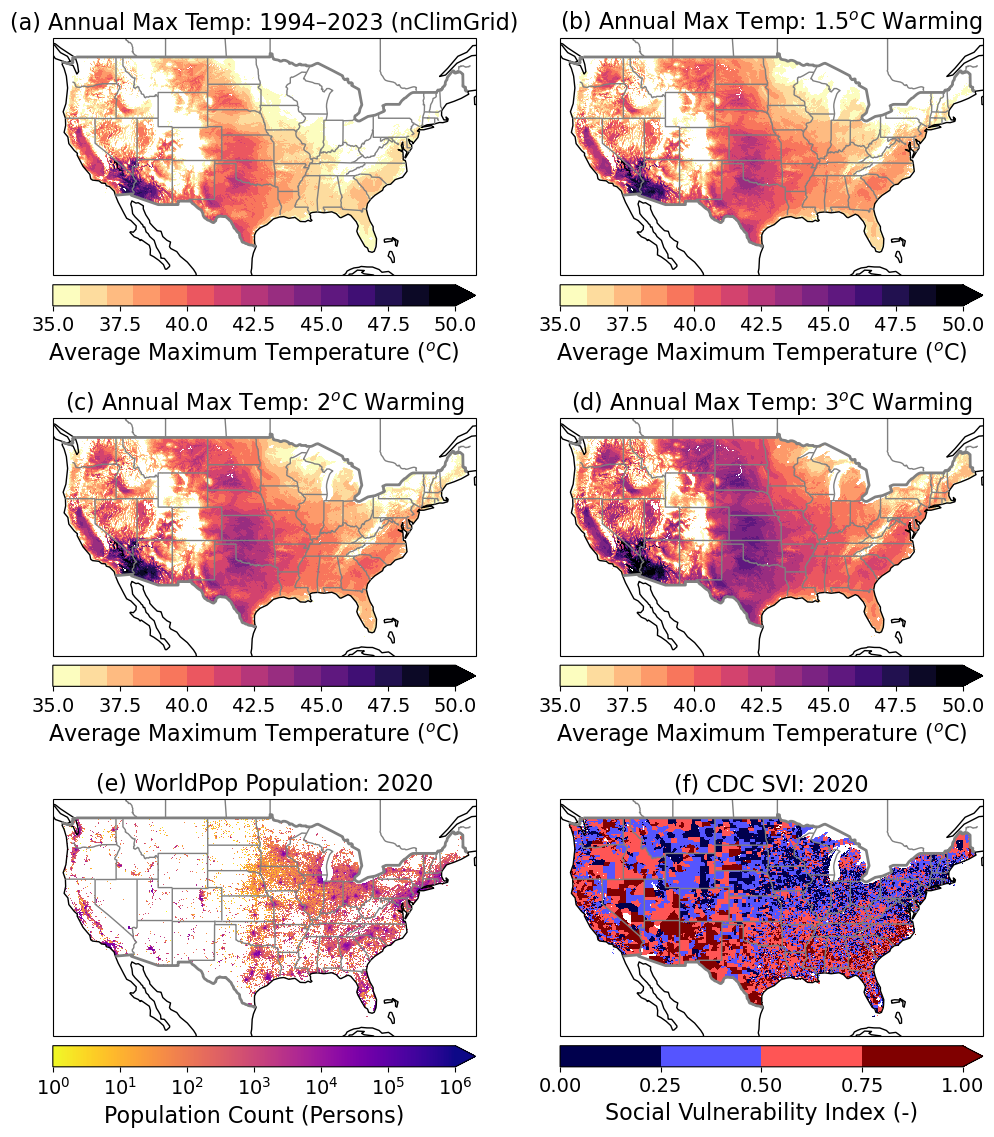

In [29]:
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

fig = plt.figure(figsize=(12,14))
extent = [-126, -66, 22, 47]
a = 3
b = 2
fsize = 16

# (a) nClimGrid 1994–2023
ax = plt.subplot(a,b,1,projection = ccrs.Miller(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
ax.add_feature(states_provinces, edgecolor='gray')
plotvalue = nclimgrid_tasmax.mean(dim='time').where(lambda x: (x > 0) & (x > 35))
im1 = plt.pcolormesh(plotvalue.lon, plotvalue.lat, plotvalue,
                     cmap=plt.cm.get_cmap('magma_r',15),
                     vmin=35, vmax=50,
                     transform=ccrs.PlateCarree())
plt.title('(a) Annual Max Temp: 1994–2023 (nClimGrid)', fontsize=fsize, ha='center')
cbar1 = plt.colorbar(im1, extend='max', orientation='horizontal', shrink=1, pad=0.03)
cbar1.ax.tick_params(labelsize=fsize - 2)
cbar1.set_label('Average Maximum Temperature ($^o$C)', fontsize=fsize)

# (b–d) CMIP6 GWLs: 1.5°C, 2°C, 3°C median
for i, gwl in enumerate(['1.5', '2', '3']):
    ax = plt.subplot(a,b,i+2,projection = ccrs.Miller(central_longitude=0))
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=1)
    ax.set_extent(extent)
    ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
    ax.add_feature(states_provinces, edgecolor='gray')
    plotvalue = da_slice_all_gwls_allmodels.sel(gwl=gwl).median(dim='model').where(lambda x: (x > 0) & (x > 35))
    im1 = plt.pcolormesh(plotvalue.longitude, plotvalue.latitude, plotvalue,
                         cmap=plt.cm.get_cmap('magma_r',15),
                         vmin=35, vmax=50,
                         transform=ccrs.PlateCarree())
    plt.title(f'({chr(98+i)}) Annual Max Temp: {gwl}$^o$C Warming', fontsize=fsize, ha='center')
    cbar1 = plt.colorbar(im1, extend='max', orientation='horizontal', shrink=1, pad=0.03)
    cbar1.ax.tick_params(labelsize=fsize - 2)
    cbar1.set_label('Average Maximum Temperature ($^o$C)', fontsize=fsize)

# (e) WorldPop 2020
ax = plt.subplot(a,b,5,projection = ccrs.Miller(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
ax.add_feature(states_provinces, edgecolor='gray')
plotvalue = da_pop.where(da_svi > 0)
im1 = plt.pcolormesh(plotvalue.longitude, plotvalue.latitude, plotvalue,
                     cmap=plt.cm.get_cmap('plasma_r'),
                     norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=1, vmax=1e6, base=10),
                     transform=ccrs.PlateCarree())
plt.title('(e) WorldPop Population: 2020', fontsize=fsize, ha='center')
cbar1 = plt.colorbar(im1, extend='max', orientation='horizontal', shrink=1, pad=0.03)
cbar1.ax.tick_params(labelsize=fsize - 2)
cbar1.set_label('Population Count (Persons)', fontsize=fsize)

# (f) CDC SVI
ax = plt.subplot(a,b,6,projection = ccrs.Miller(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
ax.add_feature(states_provinces, edgecolor='gray')
plotvalue = da_svi.where(da_svi > 0)
im1 = plt.pcolormesh(plotvalue.longitude, plotvalue.latitude, plotvalue,
                     cmap=plt.cm.get_cmap('seismic', 4),
                     vmin=0, vmax=1,
                     transform=ccrs.PlateCarree())
plt.title('(f) CDC SVI: 2020', fontsize=fsize, ha='center')
cbar1 = plt.colorbar(im1, ticks=np.arange(0, 1.1, 0.25), extend='max', orientation='horizontal', shrink=1, pad=0.03)
cbar1.ax.tick_params(labelsize=fsize - 2)
cbar1.set_label('Social Vulnerability Index (-)', fontsize=fsize)

# Save figure


## plot both C and F

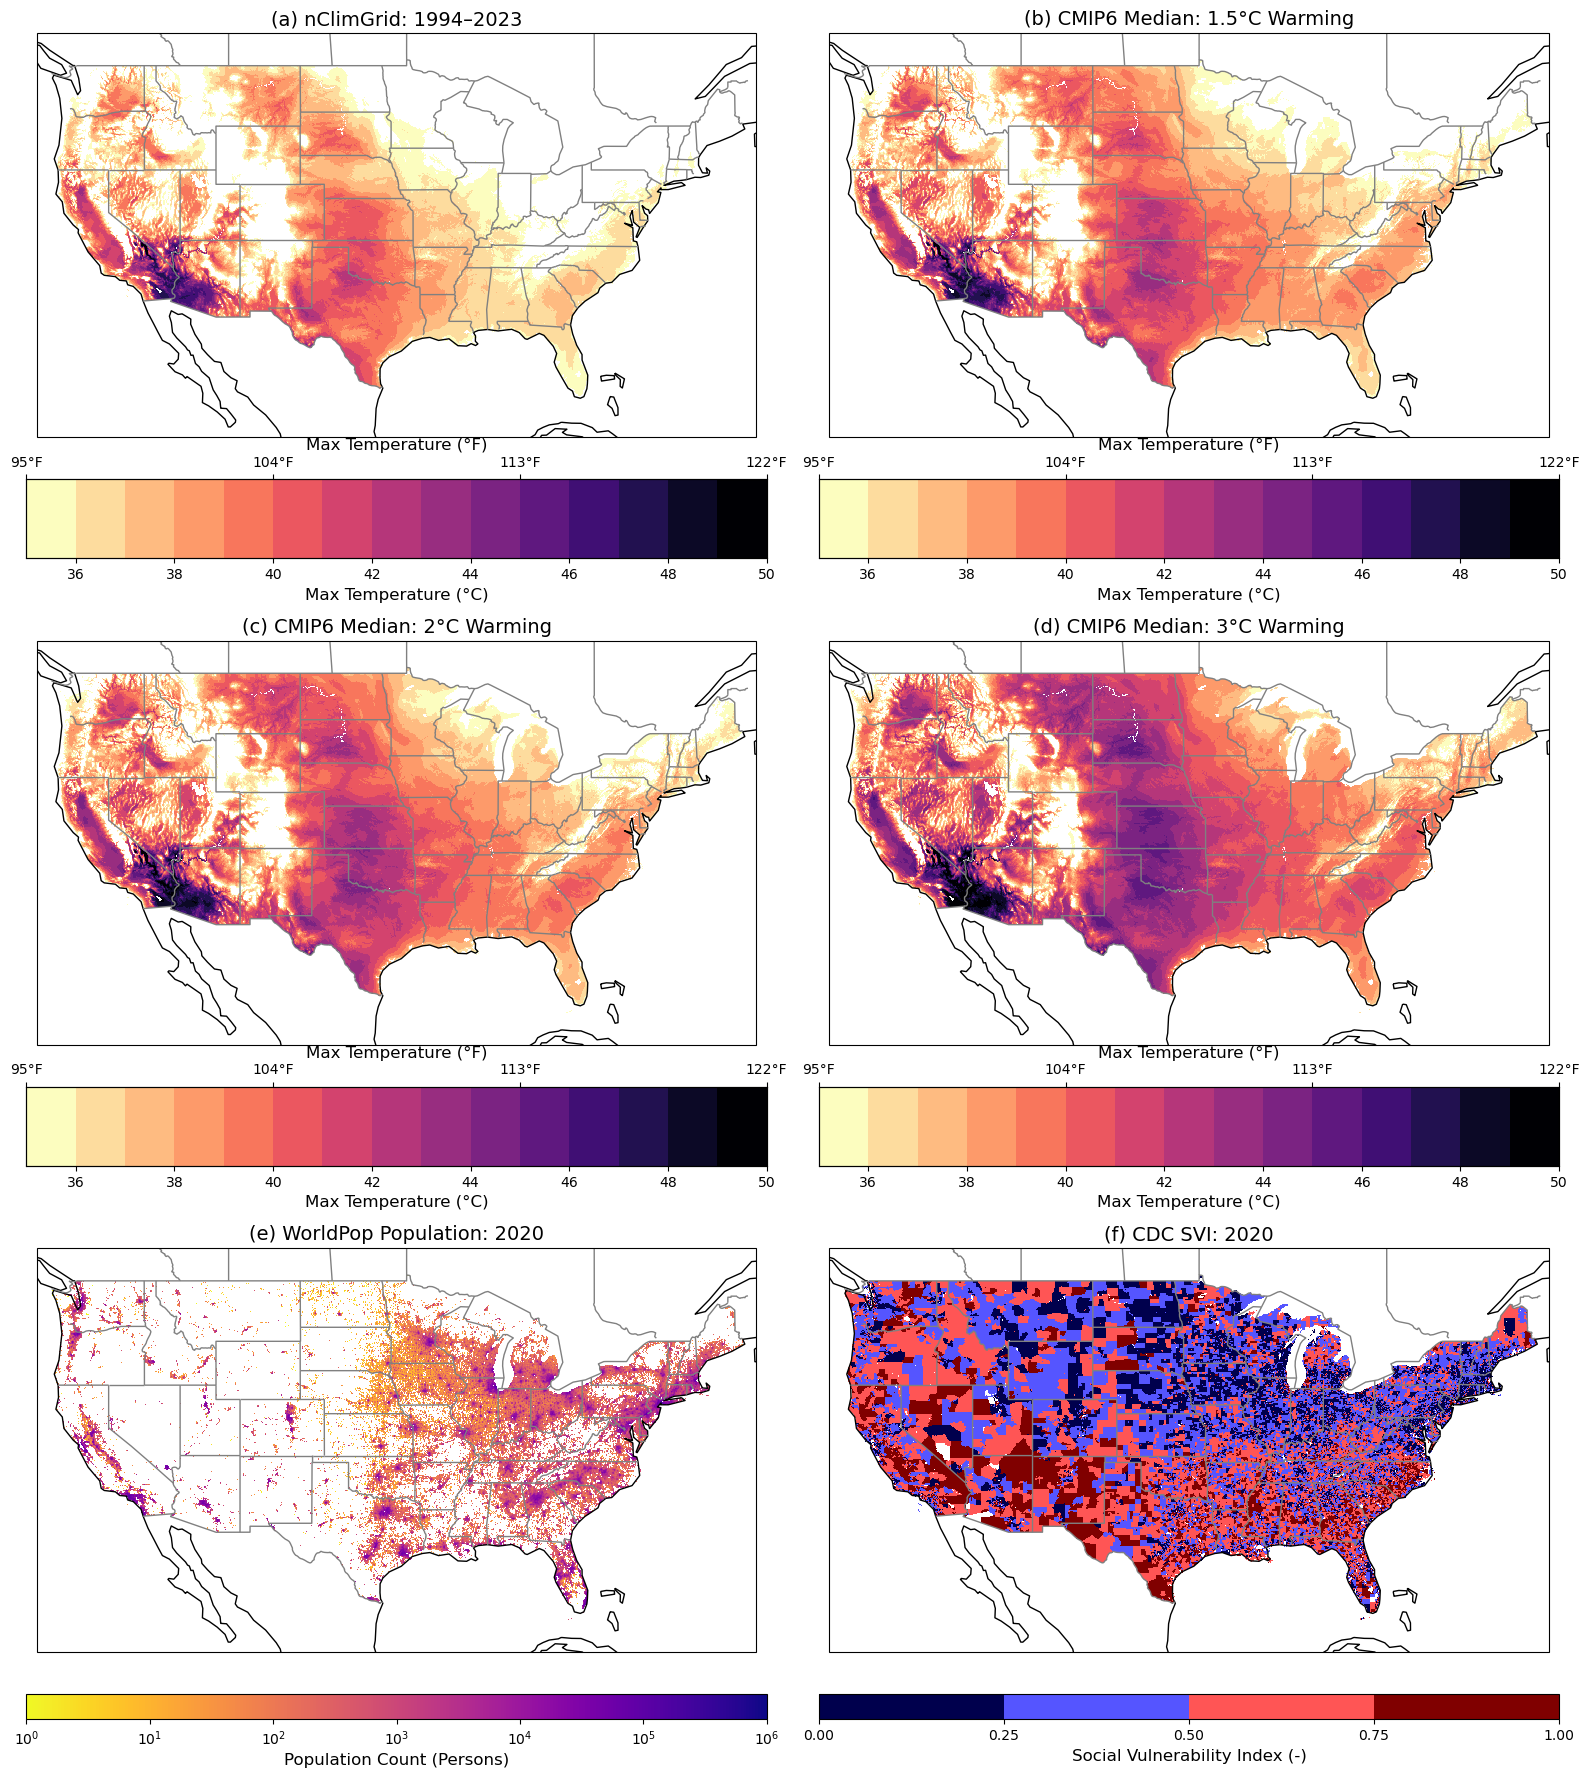

In [36]:
# Define conversion
def c_to_f(c):
    return c * 9/5 + 32

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18),
                         subplot_kw={'projection': ccrs.Miller()})
axes = axes.flatten()

# Color scale
vmin_c = 35
vmax_c = 50
cmap_temp = plt.cm.get_cmap('magma_r', 15)
norm_temp = mcolors.Normalize(vmin=vmin_c, vmax=vmax_c)

titles_temp = ['(a) nClimGrid: 1994–2023',
               '(b) CMIP6 Median: 1.5°C Warming',
               '(c) CMIP6 Median: 2°C Warming',
               '(d) CMIP6 Median: 3°C Warming']
gwl_levels = ['1.5', '2', '3']

# Plot temperature maps
for i, ax in enumerate(axes[:4]):
    ax.set_extent(extent)
    ax.coastlines(resolution='110m', linewidth=1)
    ax.add_feature(cf.BORDERS, linewidth=1, color='gray')
    ax.add_feature(states_provinces, edgecolor='gray')

    if i == 0:
        plotvalue = nclimgrid_tasmax.mean(dim='time').where(lambda x: (x > 0) & (x > vmin_c))
        lon = plotvalue.lon
        lat = plotvalue.lat
    else:
        gwl = gwl_levels[i - 1]
        plotvalue = da_slice_all_gwls_allmodels.sel(gwl=gwl).median(dim='model').where(lambda x: (x > 0) & (x > vmin_c))
        lon = plotvalue.longitude
        lat = plotvalue.latitude

    im = ax.pcolormesh(lon, lat, plotvalue, cmap=cmap_temp, norm=norm_temp, transform=ccrs.PlateCarree())
    ax.set_title(titles_temp[i], fontsize=14)

    # Add horizontal Celsius colorbar with reduced vertical height
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
    cbar.ax.set_box_aspect(0.15)  # Reduce vertical height
    cbar.set_label('Max Temperature (°C)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Add Fahrenheit ticks above
    cbar_ax = cbar.ax
    cbar_f_ax = cbar_ax.twiny()
    cbar_f_ax.set_xlim(c_to_f(vmin_c), c_to_f(vmax_c))
    cbar_f_ax.set_xticks([c_to_f(t) for t in range(vmin_c, vmax_c+1, 5)])
    cbar_f_ax.set_xticklabels([f'{int(t)}°F' for t in cbar_f_ax.get_xticks()])
    cbar_f_ax.set_xlabel('Max Temperature (°F)', fontsize=12)
    cbar_f_ax.tick_params(labelsize=10)

# (e) WorldPop
ax = axes[4]
ax.set_extent(extent)
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1, color='gray')
ax.add_feature(states_provinces, edgecolor='gray')
plotvalue = da_pop.where(da_svi > 0)
im = ax.pcolormesh(plotvalue.longitude, plotvalue.latitude, plotvalue,
                   cmap=plt.cm.get_cmap('plasma_r'),
                   norm=mcolors.SymLogNorm(linthresh=1, linscale=1, vmin=1, vmax=1e6, base=10),
                   transform=ccrs.PlateCarree())
ax.set_title('(e) WorldPop Population: 2020', fontsize=14)
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Population Count (Persons)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# (f) CDC SVI
ax = axes[5]
ax.set_extent(extent)
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cf.BORDERS, linewidth=1, color='gray')
ax.add_feature(states_provinces, edgecolor='gray')
plotvalue = da_svi.where(da_svi > 0)
im = ax.pcolormesh(plotvalue.longitude, plotvalue.latitude, plotvalue,
                   cmap=plt.cm.get_cmap('seismic', 4),
                   vmin=0, vmax=1,
                   transform=ccrs.PlateCarree())
ax.set_title('(f) CDC SVI: 2020', fontsize=14)
cbar = fig.colorbar(im, ax=ax, ticks=np.arange(0, 1.1, 0.25), orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Social Vulnerability Index (-)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Save
plt.tight_layout()
fig.savefig('figures/Figure_1_Temp_C_and_F_Pop_SVI_horizontal_short_colorbar.png', dpi=300, bbox_inches='tight')